In [16]:
import numpy as np
import pandas as pd
path = "../ESX01_2706/ESX01_2706_S.csv"
df = pd.read_csv(path, delimiter=";", decimal=',')

In [2]:
df.head()

,Time,CPU usage,Used memory,Number of bytes received,Number of bytes transmitted,RLATE,WLATE
0,2019-06-27T00:00:00+02:00,1.022600e+10,2.250000e+11,5877248.0,31498752.0,8.0,7.0
1,2019-06-27T00:02:00+02:00,9.362500e+09,2.250000e+11,4866560.0,5431296.0,49.5,72.5
2,2019-06-27T00:04:00+02:00,8.490000e+09,2.250000e+11,5247488.0,5050368.0,47.0,20.0
3,2019-06-27T00:06:00+02:00,9.079000e+09,2.250000e+11,6056960.0,6340608.0,54.5,36.5
4,2019-06-27T00:08:00+02:00,7.504000e+09,2.250000e+11,4986368.0,5183488.0,11.0,14.5


In [3]:
df.dtypes

Time                            object
CPU usage                      float64
Used memory                    float64
Number of bytes received       float64
Number of bytes transmitted    float64
RLATE                          float64
WLATE                          float64
dtype: object

In [4]:
x=df['Time'][0]

In [5]:
type(x)

str

In [6]:
x

'2019-06-27T00:00:00+02:00'

In [7]:
x.split('T')[-1].split(':')

['00', '00', '00+02', '00']

In [8]:
df['is_in_8and12'] = df.Time.map(lambda x: x.split('T')[-1].split(':')[0])
df['is_in_8and12'] = df['is_in_8and12'].map(lambda x: True if 8<=int(x)<=12 else 0 )
df8to12 = df[df.is_in_8and12==True]
df8to12.head()

,Time,CPU usage,Used memory,Number of bytes received,Number of bytes transmitted,RLATE,WLATE,is_in_8and12
240,2019-06-27T08:00:00+02:00,1.387900e+10,2.250000e+11,1658368.0,2077696.0,14.0,34.0,True
241,2019-06-27T08:02:00+02:00,9.634500e+09,2.250000e+11,1909760.0,9361408.0,14.5,30.5,True
242,2019-06-27T08:04:00+02:00,9.708500e+09,2.250000e+11,1655296.0,1817088.0,11.5,5.5,True
243,2019-06-27T08:06:00+02:00,9.926000e+09,2.250000e+11,1412608.0,1516032.0,37.0,15.0,True
244,2019-06-27T08:08:00+02:00,1.078250e+10,2.250000e+11,1795584.0,1858560.0,12.5,2.5,True


In [9]:
df8to12.shape

(150, 8)

In [17]:
# some params
contamination = 0.02
random_state = 78

In [18]:
df = df.dropna()
df.shape

(715, 7)

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = df.drop(['Time'], axis=1)
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled.head()

,CPU usage,Used memory,Number of bytes received,Number of bytes transmitted,RLATE,WLATE
0,0.579689,0.925926,0.083647,0.642853,0.032172,0.021180
1,0.530739,0.925926,0.068396,0.107084,0.254692,0.219365
2,0.481279,0.925926,0.074144,0.099255,0.241287,0.060514
3,0.514668,0.925926,0.086359,0.125773,0.281501,0.110439
4,0.425385,0.925926,0.070204,0.101991,0.048257,0.043873


In [20]:
n_clusters = 3
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_scaled)

def thresholds_for_anomalie(kmeans, n_clusters=n_clusters, ):
    
    """
    return the rayon of each clusters"""
    cluster_thresholds = {}
    for i in range(n_clusters):
        nb_of_obs_in_this_cluster = sum(kmeans.labels_) 
        cluster_thresholds[i] = nb_of_obs_in_this_cluster/len(kmeans.labels_)
        
    
    

# Isolation forest

In [21]:
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [22]:
clf = IsolationForest(behaviour='new', max_samples=100,
                      random_state=147, contamination=0.02)
# contamination = 0.02 says that we fixed 2% of outliers 
clf.fit(df_scaled)
y_pred_train = clf.predict(df_scaled)

## Using PCA to visualizer the result

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df_scaled)
df_scaled_transform = pca.transform(df_scaled)

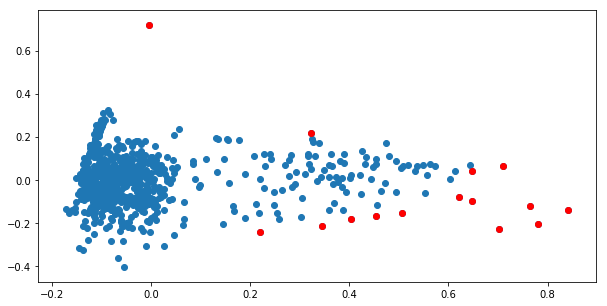

In [31]:
plt.figure(figsize=(10,5))
plt.scatter(df_scaled_transform[:,0], df_scaled_transform[:,1])
#plt.plot([1,2,3], [3,4,5])
outliers = df_scaled_transform[y_pred_train==-1]
plt.scatter(outliers[:,0], outliers[:,1], color='red')
plt.show()

In [32]:
pca.explained_variance_ratio_

array([0.49853224, 0.2278645 ])

With 2 dimensional reduction, we get also 79.7% of variance, which is a good PCA. This method give a good visualization for our model.
 However, we see that our data separate clearly in 2 groups, and have a particular  geometric form. We must to find a method that is more convenient for this data.

# Method ElipticEnvelope-Method using Mahanalobis metric

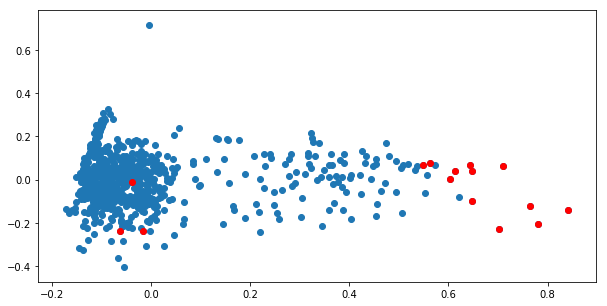

In [27]:
from sklearn.covariance import EllipticEnvelope
cov = EllipticEnvelope(random_state=random_state, contamination=contamination).fit(df_scaled)
y_pred_train_ellipticEnvelope = cov.predict(df_scaled)

plt.figure(figsize=(10,5))
plt.scatter(df_scaled_transform[:,0], df_scaled_transform[:,1])
#plt.plot([1,2,3], [3,4,5])
outliers = df_scaled_transform[y_pred_train_ellipticEnvelope==-1]
plt.scatter(outliers[:,0], outliers[:,1], color='red')
plt.show()

# Nearest Neighhors

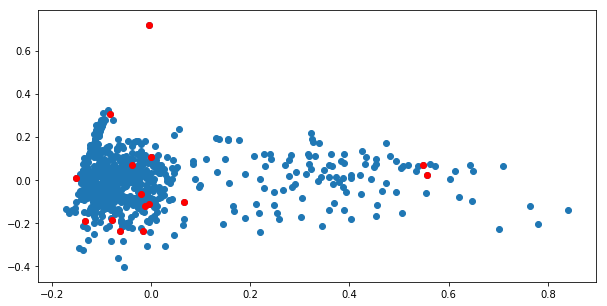

In [28]:
from sklearn.neighbors import LocalOutlierFactor
neigh = LocalOutlierFactor(n_neighbors=3, contamination=contamination)
y_pred_train_neigh = neigh.fit_predict(df_scaled)
#y_pred_train_neigh = neigh.predict(df_scaled)

plt.figure(figsize=(10,5))
plt.scatter(df_scaled_transform[:,0], df_scaled_transform[:,1])
outliers = df_scaled_transform[y_pred_train_neigh==-1]
plt.scatter(outliers[:,0], outliers[:,1], color='red')
plt.show()

# To see how the method work on the data tranform( train and predict on the data set of 2 dimension)

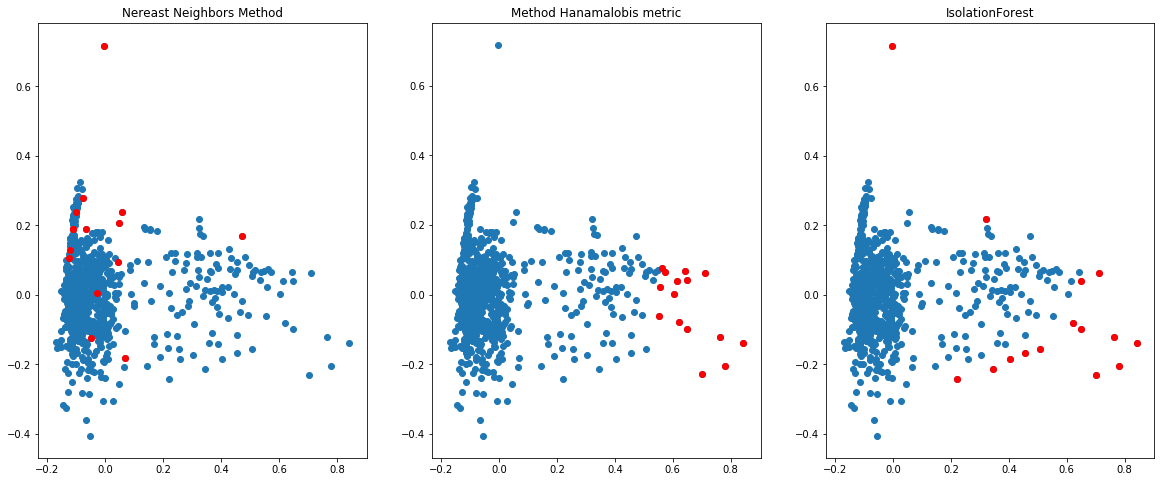

In [29]:
neigh = LocalOutlierFactor(n_neighbors=3, contamination=0.02)
y_pred_train_neigh = neigh.fit_predict(df_scaled_transform)


plt.figure(figsize=(20,8))
plt.subplot(131)
plt.scatter(df_scaled_transform[:,0], df_scaled_transform[:,1])
outliers = df_scaled_transform[y_pred_train_neigh==-1]
plt.scatter(outliers[:,0], outliers[:,1], color='red')
plt.title('Nereast Neighbors Method')

cov = EllipticEnvelope(random_state=random_state, contamination=contamination).fit(df_scaled_transform)
y_pred_train_ellipticEnvelope = cov.predict(df_scaled_transform)
plt.subplot(132)
plt.scatter(df_scaled_transform[:,0], df_scaled_transform[:,1])
#plt.plot([1,2,3], [3,4,5])
outliers = df_scaled_transform[y_pred_train_ellipticEnvelope==-1]
plt.scatter(outliers[:,0], outliers[:,1], color='red')
plt.title('Method Hanamalobis metric')

clf = IsolationForest(behaviour='new', max_samples=100,
                      random_state=147, contamination=0.02)
clf.fit(df_scaled_transform)
y_pred_train = clf.predict(df_scaled_transform)
plt.subplot(133)
plt.scatter(df_scaled_transform[:,0], df_scaled_transform[:,1])
outliers = df_scaled_transform[y_pred_train==-1]
plt.scatter(outliers[:,0], outliers[:,1], color='red')
plt.title('IsolationForest')

plt.show()